# Mini-project n° 2 – Conditional VAEs

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
import itertools


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# VAE Standards VS. VAE Conditionnels

Les Autoencodeurs Variationnels Conditionnels (VAEs Conditionnels) s'appuient, tout comme les VAE standards, sur un modèle : encodeur  - décodeur avec compression des données dans un espace latent intermédiaire.

La principale différence est l'introduction d'entrées conditionnelles qui permettent au modèle de générer des échantillons de données en fonction de conditions ou d'attributs spécifiques. L'espace latent est lui même un espace latent conditionnel, la distribution de la variable latente $z$ dépendant de ces attributs.

Les informations présentées dans ce projet proviennent des sources suivantes:

- Nicolas Thome, Clément Rambour, Nicolas Audebert. Auto-encodeurs variationnels. Cnam. https://cedric.cnam.fr/vertigo/cours/RCP211/auto-encodeurs-variationnels.html. 2023.
- Nicolas Thome, Clément Rambour, Nicolas Audebert. Auto-encodeurs variationnels. Cnam. https://cedric.cnam.fr/vertigo/cours/RCP211/TP8-CVAE_PixelCNN.html. 2024
- Joseba Dalmau. Autoencoders and Variational Autoencoders. 2024


### VAE standards

En effet, dans un modèle de VAE "classique" le modèle de génération des données est obtenu via la formule suivante : 

$p(x) = \int p(x|z) p(z) dz$, intégrale difficile à calculer. On cherche alors plutôt à approximer $p(z|x)$ $\Bigl($ avec $p(z|x) = \frac{p(x|z) p(z)}{p(x)} \Bigr)$ qu'on ne connaît pas non plus mais qu'on veut approximer par une autre distribution $q(z|x)$.

Pour choisir $q(z|x)$, on veut s’approcher au maximum du véritable postérieur $p(z|x)$. On cherche pour cela à trouver les paramètres de $q $ qui minimisent l’écart entre les deux distributions. Le choix le plus courant pour mesurer cet écart est de calculer la divergence de Kullback-Leibler entre les deux probabilités, donnée par la formule suivante : 

$$KL(q(x)||p(x)) = \mathbb{E}_{q}(x)[log \:q(x)−log \:p(x)]$$

Minimiser cette divergence revient en fait à maximiser l'expression :

$$\mathbb{E}_{q(z|x)}[log \:p(x|z)]−KL(q(z|x)||p(z))$$

Ce terme est maximisé lorsque l'on a :

1- la maximisation de la log-vraisemblance, c’est-à-dire que les variables latentes $z$ permettent de prédire correctement x <br>
2- la minimisation d’une pénalité correspondant à la divergence entre $q$ et l'a priori $p$

### VAE conditionnels

Dans un VAE conditionnel, on l'a dit précédemment, la variable latente $z$ est condtionnée par c. Nous avons donc un espace latent et une distribution $p(z)$
différents pour chaque valeur du conditionnement c. Dans ce cas là, l'expression que l'on cherche alors  à minimiser est la suivante :

$$\mathbb{E}_{q(z|x,c)}[log \:p(x|z,c)]−KL(q(z|x,c)||p(z|c))$$


## Listes des hyperparamètres

Les hyperparamètres de notre modèle sont : 

- batch size = Le nombre d'échantillons sur lesquels le modèle apprend avant de mettre à jour ses paramètres internes (poids du réseau...)
- epochs = Le nombre de fois où l'entièreté du jeu de données est utilisée pour l'apprentissage. Une valeur trop faible peut conduire à du sous-apprentissage et au contraire une valeur trop élevée à du surapprentissage
- latent_dim = La taille de l'espace latent
- learning_rate = Le taux d'apprentissage. Il contrôle la vitesse à laquelle le modèle apprend.
- kl_weights = La liste des poids pour la divergence KL (Kullback-Leibler)
- beta = Ajuste l'importance de la divergence dans la fonction de perte

La fonction de perte utilisée ci-après est définie de la manière suivante :

<div style="text-align: center;">
    Loss = BCE + beta * KLD
</div>
où BCE correspond à la "Binary Cross-Entropy" et KLD est la Divergence KL

Le premier terme est un terme de reconstruction : il mesure à quel point le réseau reconstruit correctement les données d’origine à partir de l’espace latent.
Le second terme est un terme de régularisation : il mesure à quel point la distribution de l'espace latent se rapproche d'une loi normale centrée réduite.

Ainsi, 3 cas sont à distinguer concernant le paramètre beta :

- beta = 1 : On accorde autant d'importance à la reconstruction qu'à la régularisation.
- beta > 1 : On donne davantage de poids à la régularisation. On fait en sorte que la distribution de l'espace latent se rapproche au plus d'une gaussienne centrée réduite. Cependant, cela peut diminuer la capacité de reconstruction du modèle.
- beta < 1 : On donne davantage de poids à la reconstruction. Le modèle apprend ainsi à capturer plus de détails dans l'image. Cependant, cela peut augmenter le risque de surapprentissage.

In [16]:
# Liste des hyperparamètres
batch_size = 128
epochs = 5
latent_dim = 2
learning_rate = 1e-3
kl_weights = [0.5, 1, 10, 100]
beta = 1

# Autres paramètres
nb_classes=10

nb_classes correspond au nombre de classes pouvant être générées par le modèle, en l'occurence 10 vêtements et accessoires.

## Chargement des données

In [17]:
# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


## Création d'un modèle d'AutoEndodeur Variationnel Conditionnel (Conditionnal VAE)

Le modèle de VAE conditionnel utilisé par la suite se construit de la manière suivante :

- **Un Encodeur** : 
    - Une couche de convolution composée de 32 filtres, un noyau de taille 4, un stride de 2 and un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques.
    - Une fonction d'activation ReLu.
    - Une couche de convolution composée de 64 filtres, un noyau de taille 4, un stride de 2 and un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques.
    - Une fonction d'activation ReLu.
    - Une couche de convolution composée de 128 filtres, un noyau de taille 3, un stride de 2 and un padding de 1..
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques.
    - Une fonction d'activation ReLu.

- **Un Espace Latent** :

Il est composé de deux couches parallèles dites "entièrement connectées" (en d'autres termes tous les neurones sont connectés à ceux de la couche précédente, qui est ici la sortie de l'encodeur E(x)).

- La première couche estime un vecteur moyenne µ(x)
- La seconde couche estime un vecteur de log-variance $\log\sigma^2(x)$

Une dernière couche entièrement connectée utilise alors ces informations pour renvoyer la variable latente z selon une distribution gaussienne : $z(x)\sim\mathcal{N}(\mu(x),Diag(\sigma(x)))$ 

- **Un Décodeur.** 
    - Une couche de déconvolution composée de 64 filtres, un noyau de taille 3, un stride de 2 and un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques
    - Une fonction d'activation ReLu
    - Une couche de déconvolution composée de 32 filtres, un noyau de taille 4, un stride de 2 and un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques
    - Une fonction d'activation ReLu
    - Une couche de déconvolution composée de 1 filtre, un noyau de taille 4, un stride de 2 and un padding de 1.
    - Une fonction d'activation Sigmoïde

**Au niveau de l'encodeur :**

Pour chacune des couches de convolution :
- Un filtre (ou noyau) est une matrice de poids qui parcourt l’image d’entrée pour extraire des caractéristiques spécifiques (de manière générale comme des contours ou des textures). La sortie de la couche est obtenue à partir d'une convolution entre l'objet en entrée et le filtre. Le paramètre kernel_size désigne la taille de la matrice.
- Un filtre apprend UNE caractéristique de l’image donc, plus il y a de filtres, plus le modèle retient de caractéristiques.
- Le stride indique de combien de pixels le filtre se déplace à chaque étape lorsqu’il parcourt l’image d’entrée (d'abord horizontalement puis verticalement). 
- Le padding consiste à ajouter des pixels autour de l'image pour essayer de préserver l'information sur les bords de l'image. Un padding de 1 signfie que l'on ajoute une rangée de pixel tout autour de l'image

L’augmentation progressive du nombre de filtres dans les couches de convolution permet de capturer des caractéristiques de plus en plus complexes des données d’entrée : les couches proches de l'entrée capturent des motifs de base et au fur et à mesure que l’on avance dans le réseau, on veut que chaque couche représente des détails plus sophistiqués. Avoir plus de filtres permet à chaque couche de détecter des motifs plus variés et spécifiques.

La couche BatchNorm permet de normaliser les sorties d'une couche de réseau lors de l'apprentissage.

**Au niveau du décodeur :**

La fonction d'activation utilisée en sortie est la fonction Sigmoïde. Elle renvoie des valeurs comprises entre 0 et 1 , ce qui est utile puisqu' avec ce réseau on cherche à générer des images en noir et blanc. Les résultats obtenus permettent donc directement d'obtenir des nuances de gris.




**Le vecteur de conditionnement c** :

Donne une information/une étiquette sur les données. Ici c indique la valeur numérique associée à une image du jeu de données (ie le numérp de la classe représentée).
La variable latente z est alors conditionnée par c.

In [18]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=10):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4 + num_classes, latent_dim) # (128*4*4) est la taille de sortie de la couche précédente
        self.fc_logvar = nn.Linear(128 * 4 * 4 + num_classes, latent_dim) 
        self.fc_decode = nn.Linear(latent_dim + num_classes, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x, c):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4) # "Applatissement" de la sortie après convolution (on restructure les donnes pour que x et c soient de meme taille)
        x = torch.cat((x,c),dim=1) # Concaténation de x et c
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

    def latent_sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        z = torch.cat((z,c),dim=1)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.latent_sample(mu, logvar)
        return self.decode(z, c), mu, logvar

## Création de la fonction de perte (loss function)

La formule de la fonction de perte est celle donnée précédemment : 

<div style="text-align: center;">
    Loss = BCE + beta * KLD
</div>

L'objectif est d'avoir un bon compromis entre reconstruction et régularisation.

Pour le terme de reconstruction, on utilise la "Binary Cross-entropy" afin d'accentuer les contrastes (on oblige les pixels à prendre des valeurs très proches de 0 ou de 1 et donc à avoir des zones de l'image très blanches et d'autres très noires).

In [19]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # terme de reconstruction 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # terme de regularisation (on cherche à se rapprocher d'une loi normale)
    return BCE + beta * KLD

## Apprentissage du modèle de VAE conditionnel

Dans un premier temps, on effectue un travail "naïf" pour l'apprentissage et la génération d'images. En d'autres termes, on utilise des valeurs non-optimisées de nos hyperparamètres afin d'avoir un premier aperçu du fonctionnement de notre modèle.

In [20]:
# Initialisation du modèle de VAE model
vae = ConvVAE(latent_dim=latent_dim, num_classes=nb_classes)
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate) 
# On choisit l'optimizer Adam, couramment utilisé dans l'industrie pour ses performances

# On entraîne le modèle sur chaque epoch
for epoch in range(1, epochs + 1):
    vae.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=nb_classes).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar, beta)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}') # Affiche la fonction de perte

Epoch 1, Training loss: 272.9073
Epoch 2, Training loss: 257.8058
Epoch 3, Training loss: 256.2988
Epoch 4, Training loss: 255.1900
Epoch 5, Training loss: 254.6263


## Génération des images

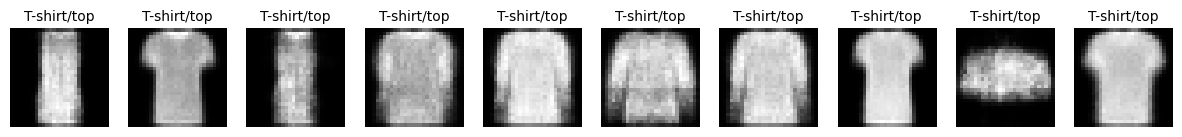

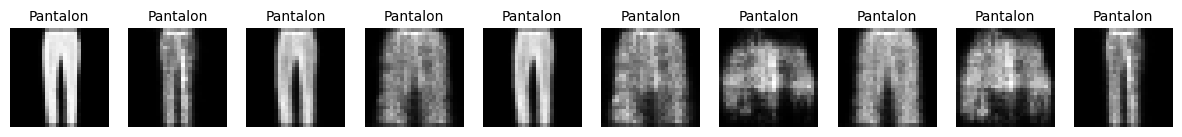

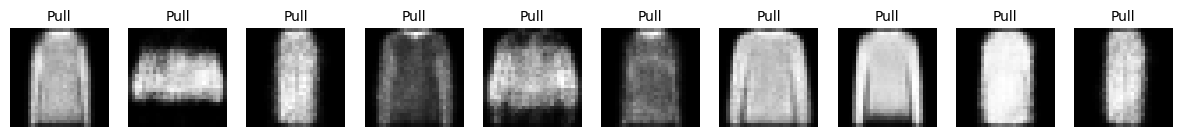

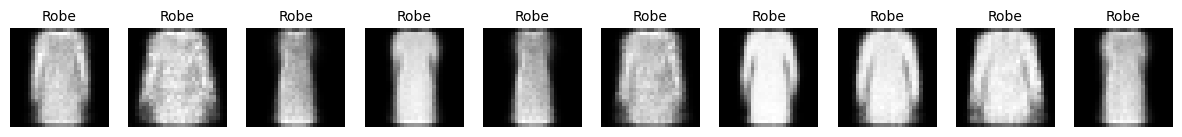

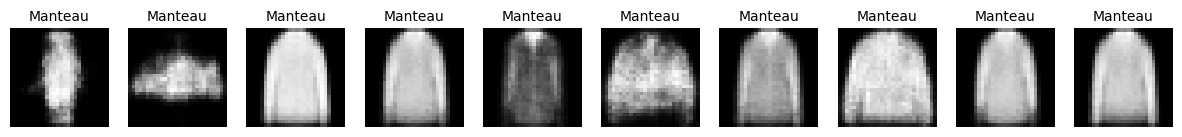

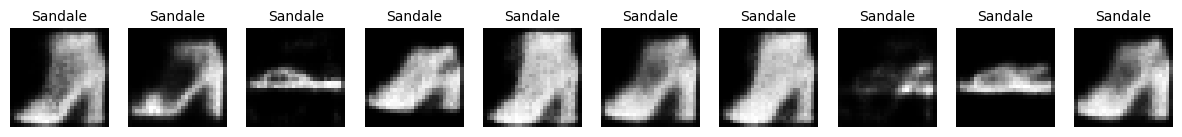

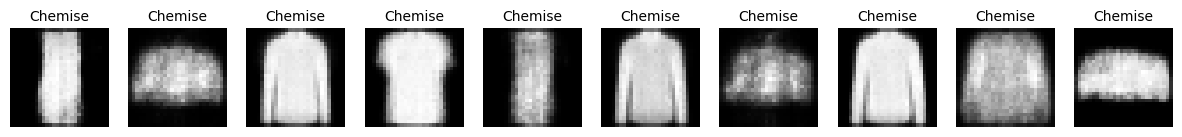

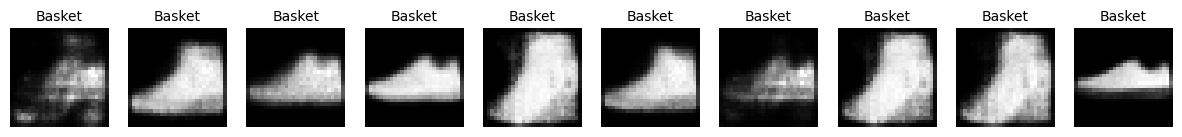

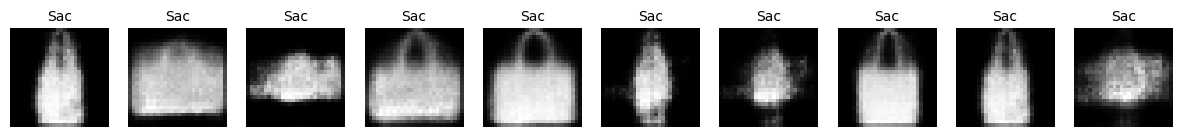

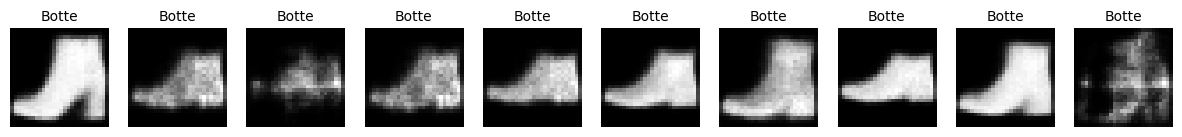

In [21]:
def generate_sample(num_samples=10, objet="robe"):
# digit est la valeur conditionelle c'est-à-dire la classe que l'on veut générer
    vae.eval()
    with torch.no_grad():

        # Échantillonage selon une loi normale
        z = torch.randn(num_samples, latent_dim).to(device)

        # On ajoute la condition ie la valeur que l'on veut générer
        condition = torch.zeros(num_samples,10, dtype=int).to(device)
        condition[:, objet] = 1 # indique que c'est la valeur digit que l'on cherche à générer

        # On génère l'image
        samples = vae.decode(z, condition)
        samples = samples.cpu().view(num_samples, 1, 28, 28)

        class_names = [
            "T-shirt/top", "Pantalon", "Pull", "Robe", "Manteau",
            "Sandale", "Chemise", "Basket", "Sac", "Botte"
        ]

        fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
            ax[i].set_title(class_names[objet], fontsize=10)
        plt.show()


for classe in range(nb_classes):
    generate_sample(num_samples=10, objet=classe) # on génère 10 échantillons pour chaque classe

## Optimisation des paramètres

L'objectif de cette section est de tester différentes combinaisons d'hyperparamètres afin de déterminer celle qui est la plus optimale. Pour cela, pour chaque combinaison on calcule la valeur de la fonction de perte obtenue à la fin de l'apprentissage. On regarde alors quelle combinaison nous permet d'avoir une valeur minimale. Nos images seront ensuite générées avec cette combinaison d'hyperparamètres.

Afin de limiter les temps de calcul, 3 valeurs ont été testées pour chaque hyperparamètre que l'on a voulu optimiser.

In [ ]:
# Liste des hyperparamètres
batch_size_list = [32, 64, 128]
epochs_list = [5, 10, 50]
latent_dim_list = [2, 10, 64]
beta_list = [0.5, 1, 2]

def Optimisation(batch_size_list, epochs_list, latent_dim_list, beta_list) :
    combinations = list(itertools.product(batch_size_list, epochs_list, latent_dim_list, beta_list))
    loss_list = []
    param_list = []

    for batch_size_opt, epochs_opt, latent_dim_opt, beta_opt in  combinations:
        train_loader_opt = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_opt, shuffle=True)
        test_loader_opt = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_opt, shuffle=False)

        # Initialisation du modèle de VAE model
        vae = ConvVAE(latent_dim=latent_dim_opt, num_classes=nb_classes)
        vae.to(device)
        optimizer = optim.Adam(vae.parameters(), lr=learning_rate) 
        # On choisit l'optimizer Adam, couramment utilisé dans l'industrie pour ses performances

        # On entraîne le modèle sur chaque epoch
        for epoch in range(1, epochs_opt + 1):
            vae.train()
            running_loss = 0.0
            for batch_idx, (data, labels) in enumerate(train_loader_opt):
                data = data.to(device)
                labels = F.one_hot(labels, num_classes=nb_classes).to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar = vae(data, labels)
                loss = loss_function(recon_batch, data, mu, logvar, beta_opt)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            
            epoch_loss = running_loss / len(train_loader_opt.dataset)
        loss_list.append(epoch_loss)
        param_list.append([batch_size_opt, epochs_opt, latent_dim_opt, beta_opt])

    print(f"Valeur minimale de la fonction de perte : {min(loss_list)}, pour les paramètres suivants :")
    print(f"batch_size_opt : {param_list[loss_list.index(min(loss_list))][0]}")
    print(f"epochs_opt : {param_list[loss_list.index(min(loss_list))][1]}")
    print(f"latent_dim_opt : {param_list[loss_list.index(min(loss_list))][2]}")
    print(f"beta_opt : {param_list[loss_list.index(min(loss_list))][3]}")


In [24]:
Optimisation(batch_size_list, epochs_list, latent_dim_list, beta_list)

Valeur minimale de la fonction de perte : 224.15730145670574, pour les paramètres suivants :
batch_size_opt : 64
epochs_opt : 50
latent_dim_opt : 64
beta_opt : 0.5


On va ensuite chercher à voir l'influence de chaque paramètre sur les valeurs de la fonction de perte. Cette fois-ci, pour chaque graphe obtenu, 3 des 4 paramètres sont fixés tandis que le troisème varie.

In [6]:
# Liste des hyperparamètres
batch_size_list = [32, 64, 128]
epochs_list = [5, 10, 50]
latent_dim_list = [2, 10, 64]
beta_list = [0.5, 1, 2]

def apprentissage(batch_size_opt, epochs_opt, latent_dim_opt, beta_opt):
    loss_list = []
    param_list = []

    train_loader_opt = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_opt, shuffle=True)

    # Initialisation du modèle de VAE model
    vae = ConvVAE(latent_dim=latent_dim_opt, num_classes=nb_classes)
    vae.to(device)
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate) 
    # On choisit l'optimizer Adam, couramment utilisé dans l'industrie pour ses performances

    # On entraîne le modèle sur chaque epoch
    for epoch in range(1, epochs_opt + 1):
        vae.train()
        running_loss = 0.0
        for batch_idx, (data, labels) in enumerate(train_loader_opt):
            data = data.to(device)
            labels = F.one_hot(labels, num_classes=nb_classes).to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data, labels)
            loss = loss_function(recon_batch, data, mu, logvar, beta_opt)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader_opt.dataset)
    loss_list.append(epoch_loss)
    param_list.append([batch_size_opt, epochs_opt, latent_dim_opt, beta_opt])
    return(loss_list, param_list)




def Optimisation_graphe(batch_size_list, epochs_list, latent_dim_list, beta_list) :
    xb = []
    lossb = []
    xe = []
    losse = []
    xl = []
    lossl = []
    xbe = []
    lossbe = []
    
    for batch_opt in batch_size_list :
        torch.cuda.empty_cache()
        loss_batch, param_batch = apprentissage(batch_opt, epochs, latent_dim, beta)
        xb.append(batch_opt)
        lossb.append(loss_batch)

    plt.plot(xb, lossb, label='Fonction de perte pour des batchs différents')
    plt.xlabel('Batch')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()

    for epochs_opt in epochs_list :
        torch.cuda.empty_cache()
        loss_epoch, param_epoch = apprentissage(batch_size, epochs_opt, latent_dim, beta)
        xe.append(epochs_opt)
        losse.append(loss_epoch)

    plt.plot(xe, losse, label='Fonction de perte pour des epochs différents')
    plt.xlabel('Epochs')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()

    for latent_dim_opt in latent_dim_list :
        torch.cuda.empty_cache()
        loss_latent, param_latent = apprentissage(batch_size, epochs, latent_dim_opt, beta)
        xl.append(latent_dim_opt)
        lossl.append(loss_latent)

    plt.plot(xl, lossl, label='Fonction de perte pour des espaces latents différents')
    plt.xlabel('Espaces Latents')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()

    for beta_opt in beta_list :
        torch.cuda.empty_cache()
        loss_beta, param_beta = apprentissage(batch_size, epochs, latent_dim, beta_opt)
        xbe.append(beta_opt)
        lossbe.append(loss_beta)

    plt.plot(xbe, lossbe, label='Fonction de perte pour des beta différents')
    plt.xlabel('Beta')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()
    

On fixe initialement nos paramètres en utilisant les valeurs optimales calculées précédemment et à chaque fois on ne fait varier qu'un seul des quatre paramètres.

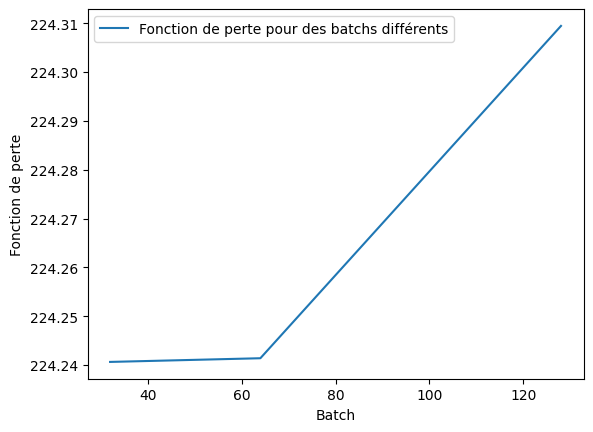

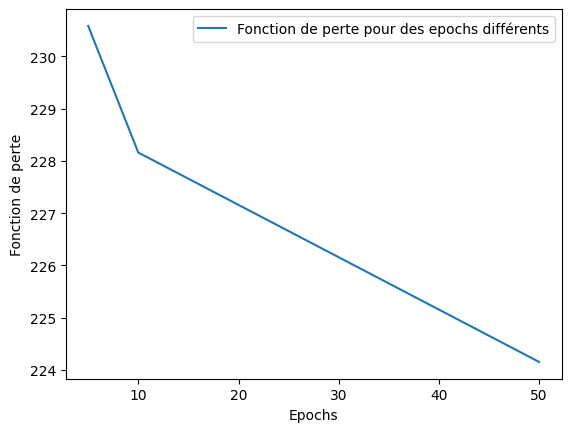

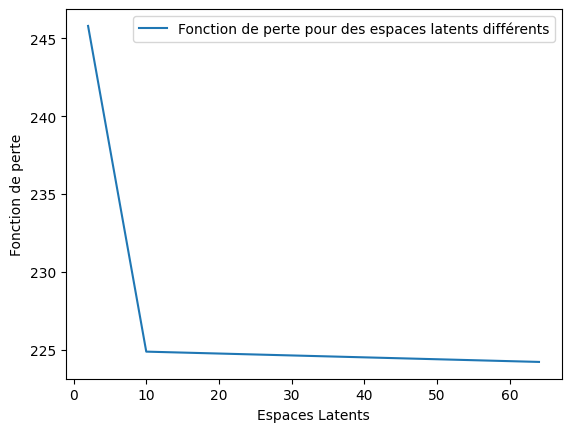

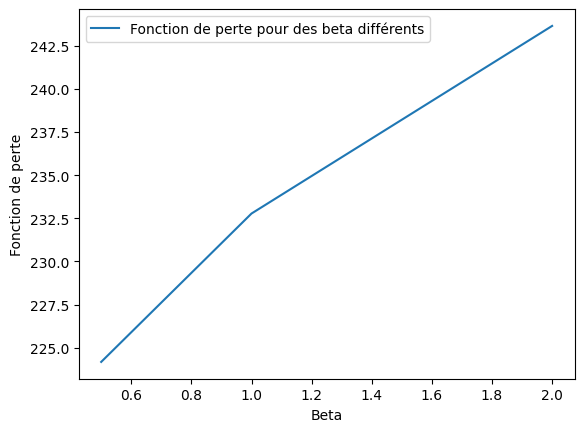

In [7]:
# Liste des hyperparamètres optimaux
batch_size = 64
epochs = 50
latent_dim = 64
beta = 0.5

Optimisation_graphe(batch_size_list, epochs_list, latent_dim_list, beta_list)

Les résultats obtenus permettent de conclure de la manière suivante :

- La taille du batch semble avoir peut d'influence sur les valeurs de la fonction perte.
- En revanche, les trois autres paramètres influencent fortement les valeurs de la fonction de perte :
   - Plus le nombre d'epochs est grand, plus la fonction de perte est faible. Cela semble logique car le modèle utilise davantage l'ensemble de données pour l'apprentissage.
  - De même, plus la taille de l'espace latent est grande, plus la fonction de perte est faible. En fait, plus la taille de l'espace latent est grande, plus le modèle capture davantage de nuances et de détails dans les données.
  - Enfin, plus beta est faible, plus la fonction de perte est faible. Là encore cela semble logique puisqu'en utilisant un beta plus faible, on donne davantage de poids à la reconstruction.
 
Ainsi, en augmentant le nombre d'epochs et la taille de l'espace latent, et en diminuant beta, on améliore les valeurs de la fonction de perte mais on augmente le risque de surapprentissage. Cependant, faire ce choix nous permet de générer des images proches de ce qui est attendu pour chaque classe de vêtements (plus qu'avec d'autres choix de paramètres) et justifie que l'on ait décidé de travailler avec ces paramètres optimaux.

In [22]:
batch_size = 64
epochs = 50
latent_dim = 64
beta = 0.5

# Initialisation du modèle de VAE model
vae = ConvVAE(latent_dim=latent_dim, num_classes=nb_classes)
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate) 
# On choisit l'optimizer Adam, couramment utilisé dans l'industrie pour ses performances

# On entraîne le modèle sur chaque epoch
for epoch in range(1, epochs + 1):
    vae.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=nb_classes).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar, beta)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}') # Affiche la fonction de perte

Epoch 1, Training loss: 260.1568
Epoch 2, Training loss: 237.3802
Epoch 3, Training loss: 234.1594
Epoch 4, Training loss: 232.3716
Epoch 5, Training loss: 231.2774
Epoch 6, Training loss: 230.4504
Epoch 7, Training loss: 229.8505
Epoch 8, Training loss: 229.2582
Epoch 9, Training loss: 228.8033
Epoch 10, Training loss: 228.4997
Epoch 11, Training loss: 228.1124
Epoch 12, Training loss: 227.8578
Epoch 13, Training loss: 227.5732
Epoch 14, Training loss: 227.3606
Epoch 15, Training loss: 227.1659
Epoch 16, Training loss: 226.9766
Epoch 17, Training loss: 226.7774
Epoch 18, Training loss: 226.6370
Epoch 19, Training loss: 226.4562
Epoch 20, Training loss: 226.3213
Epoch 21, Training loss: 226.1885
Epoch 22, Training loss: 226.0207
Epoch 23, Training loss: 225.9682
Epoch 24, Training loss: 225.8558
Epoch 25, Training loss: 225.7437
Epoch 26, Training loss: 225.6419
Epoch 27, Training loss: 225.5401
Epoch 28, Training loss: 225.4459
Epoch 29, Training loss: 225.3761
Epoch 30, Training loss

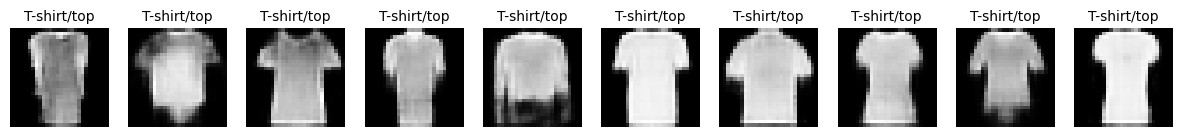

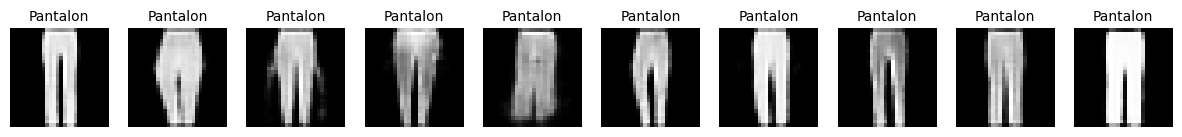

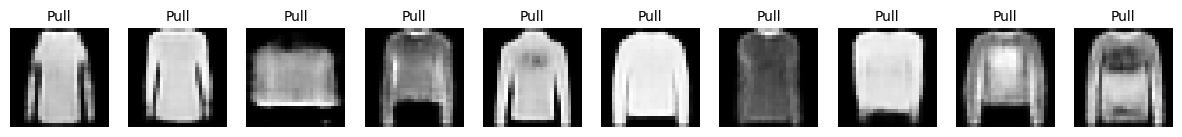

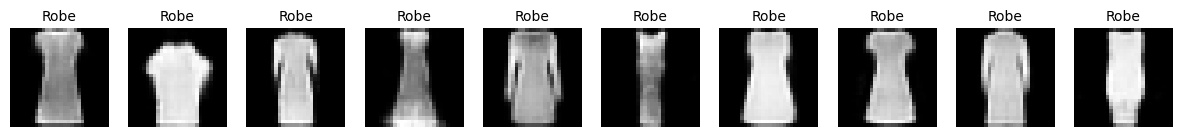

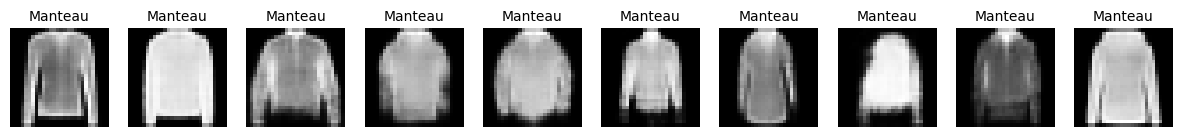

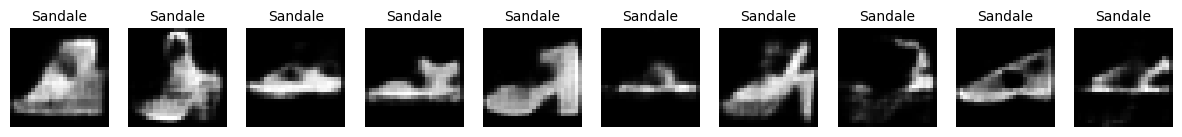

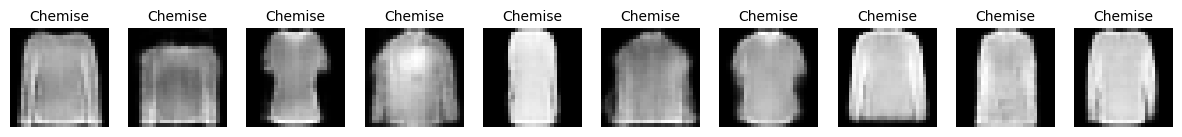

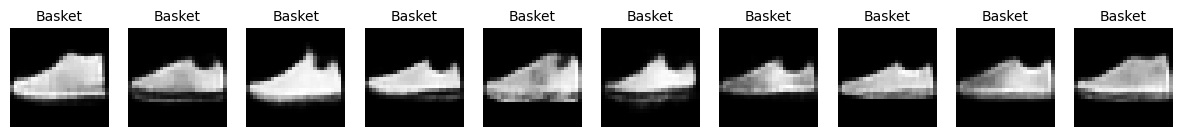

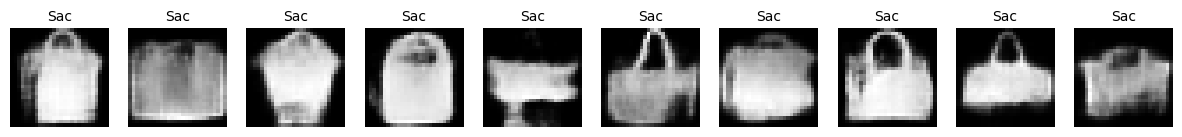

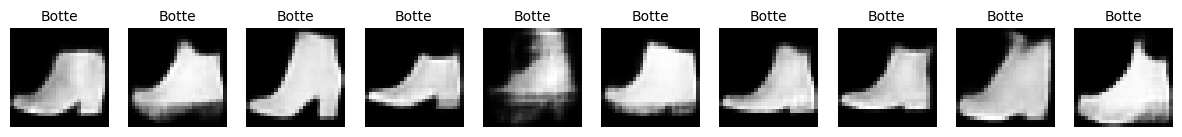

In [23]:
for classe in range(nb_classes):
    generate_sample(num_samples=10, objet=classe) # on génère 10 échantillons pour chaque classe

## Visualisation de l'espace latent

In [8]:
# On utilise la même fonction de perte mais cette fois-ci on renvoie séparément la valeur de la loss, de la cross-entropy et de la divergence
def loss_function_sep(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

In [10]:
kl_weights = [0.5, 1, 10, 100]


Training VAE with KL Weight = 0.5
Epoch 1: Average Loss: 264.5357, BCE: 250.9925, KLD: 27.0865
Epoch 2: Average Loss: 237.9616, BCE: 225.3452, KLD: 25.2329
Epoch 3: Average Loss: 234.3975, BCE: 221.9138, KLD: 24.9674
Epoch 4: Average Loss: 232.5369, BCE: 220.1840, KLD: 24.7059
Epoch 5: Average Loss: 231.2947, BCE: 219.0504, KLD: 24.4886
Epoch 6: Average Loss: 230.5475, BCE: 218.4088, KLD: 24.2774
Epoch 7: Average Loss: 229.8046, BCE: 217.7689, KLD: 24.0714
Epoch 8: Average Loss: 229.2484, BCE: 217.2924, KLD: 23.9121
Epoch 9: Average Loss: 228.8592, BCE: 216.9624, KLD: 23.7938
Epoch 10: Average Loss: 228.4455, BCE: 216.6098, KLD: 23.6714
Epoch 11: Average Loss: 228.0418, BCE: 216.2854, KLD: 23.5128
Epoch 12: Average Loss: 227.7964, BCE: 216.0656, KLD: 23.4616
Epoch 13: Average Loss: 227.5789, BCE: 215.8801, KLD: 23.3976
Epoch 14: Average Loss: 227.2790, BCE: 215.6219, KLD: 23.3141
Epoch 15: Average Loss: 227.1128, BCE: 215.5041, KLD: 23.2174
Epoch 16: Average Loss: 226.9113, BCE: 215.3

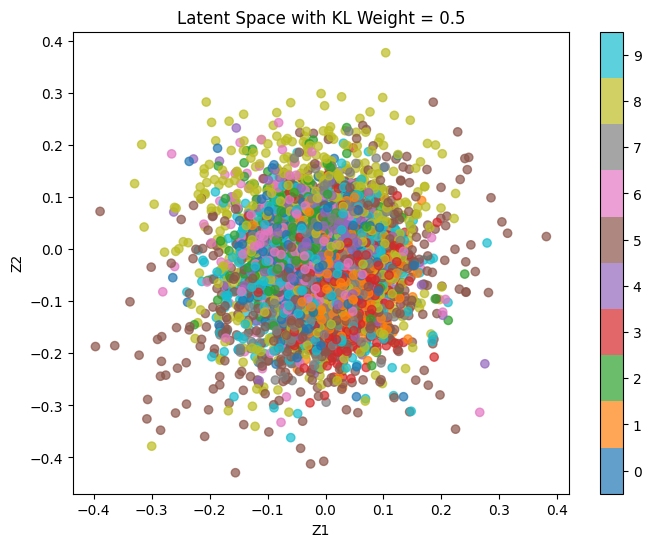


Training VAE with KL Weight = 1
Epoch 1: Average Loss: 276.7853, BCE: 261.0361, KLD: 15.7493
Epoch 2: Average Loss: 247.9701, BCE: 233.1667, KLD: 14.8034
Epoch 3: Average Loss: 244.1647, BCE: 229.5149, KLD: 14.6498
Epoch 4: Average Loss: 242.1060, BCE: 227.6354, KLD: 14.4706
Epoch 5: Average Loss: 240.6293, BCE: 226.2853, KLD: 14.3440
Epoch 6: Average Loss: 239.7402, BCE: 225.5164, KLD: 14.2238
Epoch 7: Average Loss: 238.9929, BCE: 224.8096, KLD: 14.1833
Epoch 8: Average Loss: 238.2966, BCE: 224.1948, KLD: 14.1018
Epoch 9: Average Loss: 237.7828, BCE: 223.7381, KLD: 14.0447
Epoch 10: Average Loss: 237.3748, BCE: 223.3355, KLD: 14.0392
Epoch 11: Average Loss: 236.9506, BCE: 222.9315, KLD: 14.0191
Epoch 12: Average Loss: 236.6442, BCE: 222.6420, KLD: 14.0023
Epoch 13: Average Loss: 236.3721, BCE: 222.3908, KLD: 13.9813
Epoch 14: Average Loss: 236.1422, BCE: 222.1484, KLD: 13.9938
Epoch 15: Average Loss: 235.9129, BCE: 221.9406, KLD: 13.9723
Epoch 16: Average Loss: 235.6758, BCE: 221.739

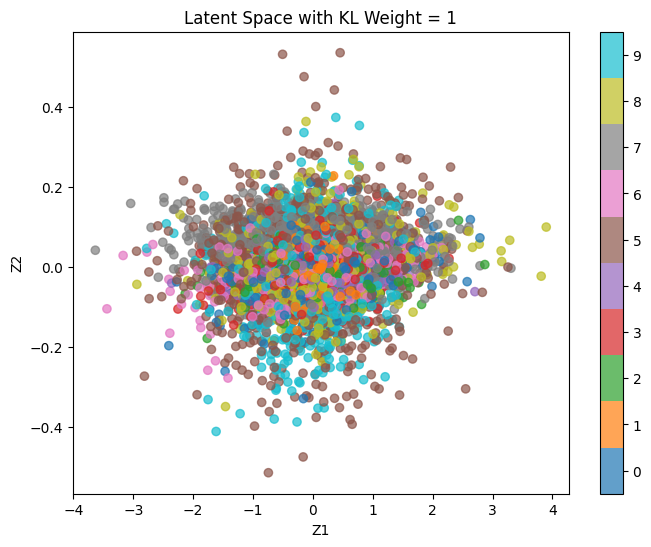


Training VAE with KL Weight = 10
Epoch 1: Average Loss: 313.8911, BCE: 296.5012, KLD: 1.7390
Epoch 2: Average Loss: 289.1358, BCE: 272.6482, KLD: 1.6488
Epoch 3: Average Loss: 285.7225, BCE: 268.7000, KLD: 1.7022
Epoch 4: Average Loss: 283.8272, BCE: 266.4445, KLD: 1.7383
Epoch 5: Average Loss: 282.5256, BCE: 264.9733, KLD: 1.7552
Epoch 6: Average Loss: 281.5707, BCE: 263.7490, KLD: 1.7822
Epoch 7: Average Loss: 280.9534, BCE: 262.8904, KLD: 1.8063
Epoch 8: Average Loss: 280.4113, BCE: 261.9108, KLD: 1.8501
Epoch 9: Average Loss: 279.7009, BCE: 260.8193, KLD: 1.8882
Epoch 10: Average Loss: 279.1626, BCE: 259.9234, KLD: 1.9239
Epoch 11: Average Loss: 278.8063, BCE: 259.4305, KLD: 1.9376
Epoch 12: Average Loss: 278.5572, BCE: 259.0303, KLD: 1.9527
Epoch 13: Average Loss: 278.3678, BCE: 258.6551, KLD: 1.9713
Epoch 14: Average Loss: 278.0912, BCE: 258.2414, KLD: 1.9850
Epoch 15: Average Loss: 277.9641, BCE: 258.1080, KLD: 1.9856
Epoch 16: Average Loss: 277.7105, BCE: 257.8312, KLD: 1.9879

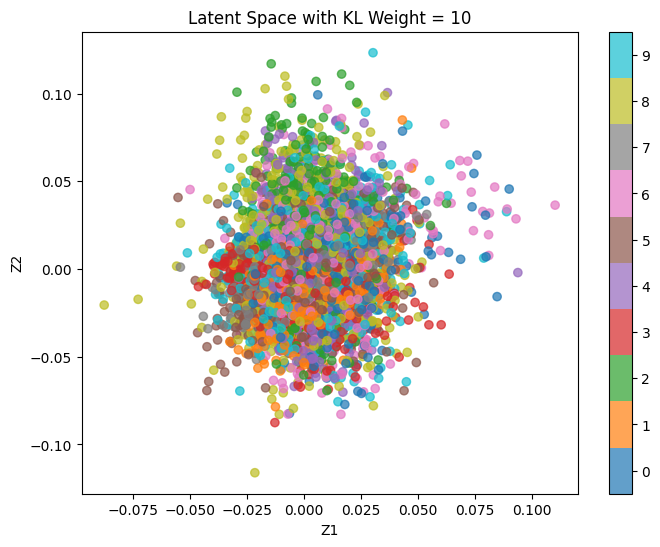


Training VAE with KL Weight = 100
Epoch 1: Average Loss: 359.8142, BCE: 329.8411, KLD: 0.2997
Epoch 2: Average Loss: 311.4833, BCE: 309.7459, KLD: 0.0174
Epoch 3: Average Loss: 310.1608, BCE: 308.7319, KLD: 0.0143
Epoch 4: Average Loss: 309.6026, BCE: 308.3077, KLD: 0.0129
Epoch 5: Average Loss: 309.3532, BCE: 308.0938, KLD: 0.0126
Epoch 6: Average Loss: 309.0394, BCE: 307.9293, KLD: 0.0111
Epoch 7: Average Loss: 308.8453, BCE: 307.8885, KLD: 0.0096
Epoch 8: Average Loss: 308.5634, BCE: 307.7771, KLD: 0.0079
Epoch 9: Average Loss: 308.3362, BCE: 307.7066, KLD: 0.0063
Epoch 10: Average Loss: 308.1970, BCE: 307.6468, KLD: 0.0055
Epoch 11: Average Loss: 308.0457, BCE: 307.6163, KLD: 0.0043
Epoch 12: Average Loss: 307.9294, BCE: 307.5597, KLD: 0.0037
Epoch 13: Average Loss: 307.8628, BCE: 307.5201, KLD: 0.0034
Epoch 14: Average Loss: 307.7804, BCE: 307.5435, KLD: 0.0024
Epoch 15: Average Loss: 307.6786, BCE: 307.4848, KLD: 0.0019
Epoch 16: Average Loss: 307.6413, BCE: 307.4971, KLD: 0.001

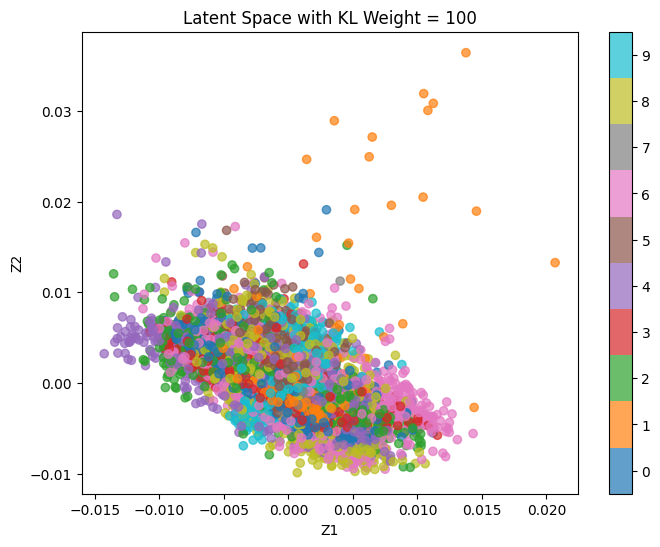

In [11]:
# Apprentissage du modèle en fonction de la divergence
def train_and_plot(kl_weight):
    model = ConvVAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = F.one_hot(labels, num_classes=nb_classes).to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(data, labels)
            loss, bce, kld = loss_function_sep(x_recon, data, mu, logvar, kl_weight)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
        
        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')
    
    # Visualisation de l'espace latent
    plot_latent_space(model, kl_weight)


def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=nb_classes).to(device)

        mu, logvar = model.encode(data, labels)
        z = mu  # Pour la visualisation on utilise la moyenne
        z = z.cpu().numpy()
        labels = labels.cpu().numpy()

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=np.argmax(labels, axis=1), cmap='tab10', alpha=0.7)  # On utilise np.argmax pour obtenir les classes
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()


# Visualisation de l'espace latent en fonction de la valeur de la divergence
for kl_weight in kl_weights:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)

On constate que, quelle que soit la valeur de la divergence utilisée, il y a une mauvaise séparation des classes :

En théorie, plus la valeur de la divergence augmente, plus on accentue la régularisation, c'est-à-dire que le modèle cherche davantage à ce que z1 et z2 s'approche d'une loi gaussienne et de fait, il est normal que les classes se distinguent moins les unes des autres. 
Or ici, même pour de faibles valeurs de divergence, il y a une enchevêtrement des classes.